# Закрепление Кластеризации (Продвинутый канал)

**Задание**

Инструкции  

1. Ознакомьтесь с содержанием демонстрационных блокнотов (Неделя 5 и аналог для синтетических данных) 

2. Создайте новый блокнот, импортируйте необходимые библиотеки (не обязательно копировать все - только нужные функции и /или классы)

3.  Для синтетических данных

3.1 Сгенерируйте данные распределенный как знак Инь-Ян или концентрические круги и проверьте, как работает алгоритм кластеризации К-Средних на этих данных

3.2 Сделайте преобразование исходных данных чтобы улучшить результаты кластеризации  
3.3 Оцените оптимальное число кластеров по методу Локтя

4. Для набора MNIST (если забыли как его загружать см Закрепление Метода Главных Компонент)

4.1 Загрузите данные MNIST. Используйте лучшие результаты Метода главных компонент в качестве входных данных

4.2 Примените кластеризацию К-Средних на этих данных

4.3 Оцените оптимальное число кластеров по методу Локтя

4.4 Оцените связь кластеров с цифрами на изображениях (pd.crosstab вам в помощь)

5. Про реальные данные

5.1 Скачайте набор данных Cars Moldova (можно сразу очищенных от дубликатов и выбросов, лучше с добавленными признаками из "Закрепления Исследовательского анализа")  
  
5.2 Выполните кластеризацию для набора данных Cars  
5.2 Выполните кластеризацию для числовых признаков. Используйте все числовые признаки, выполнив визуализацию в разных двумерных проекциях  
5.3 Оцените связь кластеров с категориальными признаками  (pd.crosstab вам в помощь)   
5.4 Сравните результаты модели при использовании данных с использованием метода главных компонент  
6. Загрузите ссылку (предварительно убедившись в открытом доступе) или ipynb файл своего решения в MS Teams 

Блокнот необходимо прилежно оформить  

* хочется видеть структуру (Заголовки разного уровня);  
* ожидается видеть не только код, но и комментарии к нему;  
* не должно быть запущенных ячеек с ошибками; 
* ожидается что рисунки адекватно оформлены (не маленького размера, есть описание того, что на рисунке)

##  Импорт данных

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification
plt.style.use('dark_background')

## Синтетические данные

In [2]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

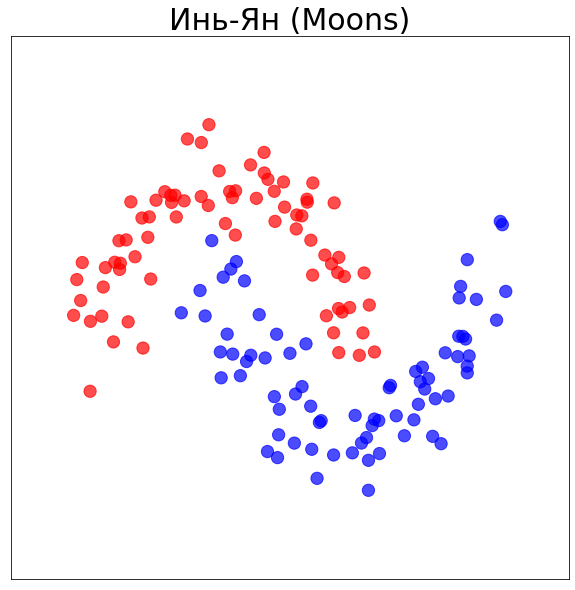

In [3]:
#@title данные { run: "auto" }
N = 150 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}

def make_binary_clf(N, method = 'moons',
                    noises = 0.2,
                    random_state = 42):
    if random_state: rng = np.random.RandomState(seed = random_state)
    X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    return X,y


fig=plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plot_data(ax,make_binary_clf(N,method = 'moons', noises = noises), 
          'Инь-Ян (Moons)')

**Кластеризация k-средних**

In [4]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter        
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state
    #-------------------------------------    
    def distance(self,X1, X2):
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)  
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)      
        return dist
    #-------------------------------------
    def init_centroids(self, X):
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1) 
    #-------------------------------------
    def transform(self,X):
        return self.predict(X)
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        return (
                distance(self.centroids,old_centroids)/
                distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):
        
        if self.centroids is None:
            self.centroids = self.init_centroids(X)
    
        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)
            
            cluster_label = self.predict(X)

            for k in range(self.n_clusters):
                
                c_idxs = np.flatnonzero(cluster_label==k)
                
                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self        
    #-------------------------------------
    def fit_transform(self, X):
        return self.fit(X).predict(X)
    
    

In [5]:
X,y = make_binary_clf(N,method = 'moons', noises=0.2, )
X.shape

(150, 2)

In [6]:
def distance(X1, X2, metric = 'euclidean', p = 2):
    if metric == 'euclidean':
        dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
    if metric == 'cityblock':
        dist = np.sum(np.abs(X1 - X2).T,axis=0)
    if metric == 'Chebyshev':
        dist = np.max(np.abs(X1 - X2).T,axis=0)  
    if metric == 'Minkowski':
        dist = np.power(np.sum(np.power(np.abs(X1 - X2),p).T,axis=0),1/p)      
    return dist

**Метод локтя**

<ipython-input-7-800d03eed7ba>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 20)
<ipython-input-7-800d03eed7ba>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 20);


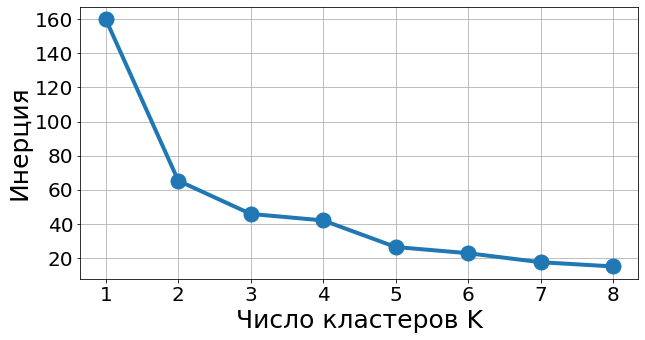

In [7]:
sse = []
list_k = list(range(1, 9))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(FontSize = 20)
plt.yticks(FontSize = 20);

**Вывод:**

Исходя из графика оптимальным количеством кластеров будет от 2 до 4.  
Проверим это визуально

Посмотрим для 2 кластеров

In [8]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    
    fig = plt.figure(figsize=(11,10))

    plt.scatter(X[:, 0], X[:, 1], 
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'k')
    
    if old_centroids is not None:
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'k')  

    plt.xticks([])
    plt.yticks([])

Мы остановились на итерации:: 5


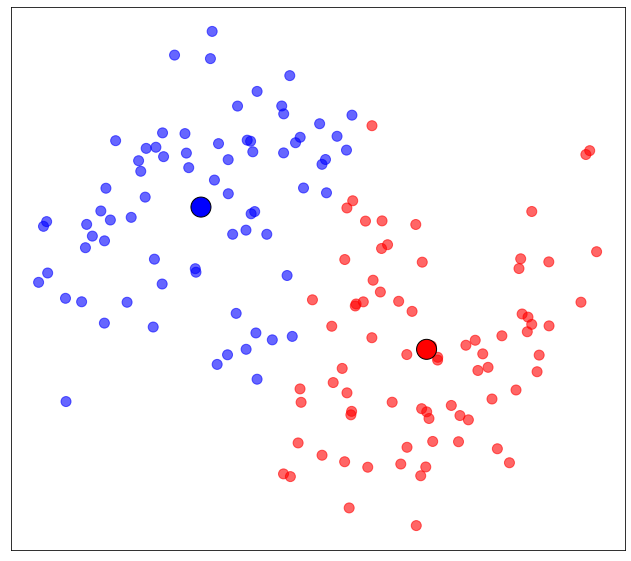

In [9]:
kmeans   = KMeans(n_clusters=2,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

Посмотрим для 3 кластеров

Мы остановились на итерации:: 11


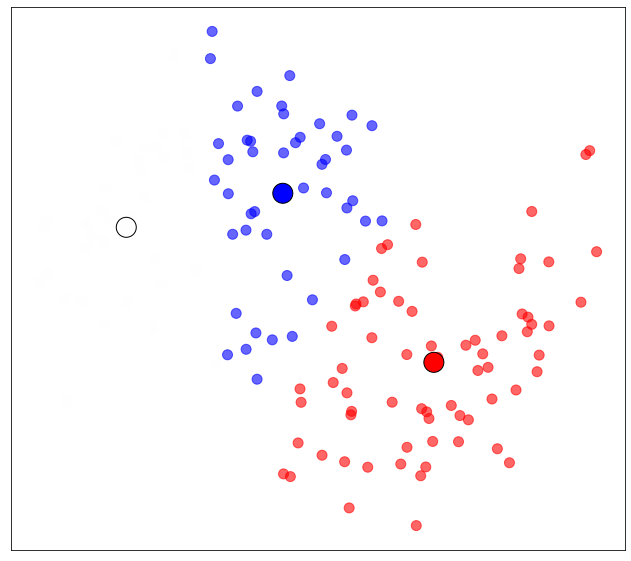

In [10]:
kmeans   = KMeans(n_clusters=3,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

In [11]:
# вообще странная картинка, от слова совсем

Посмотрим для 4 кластеров

Мы остановились на итерации:: 9


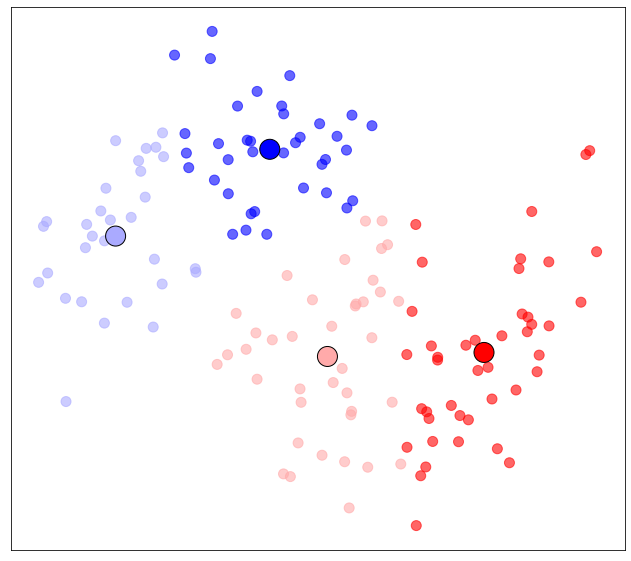

In [12]:
kmeans   = KMeans(n_clusters=4,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

Немного о метриках

In [13]:
pd.crosstab(y,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3
Метки,,,,
0,32,27,11,5
1,5,3,28,39


## Данные MNIST

In [14]:
import seaborn as sns

from sklearn.datasets import fetch_openml

### Необходимые функции

In [15]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None
    
    #--------------------------------    
    def fit(self, X):

        self.mean = np.mean(X, axis=0)
        
        # Считаем матрицу ковариации
        cov_matrix = np.cov(X - self.mean, rowvar = False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        idx = eigenvalues.argsort()[::-1] #Сортируем по возрастанию
        
        # Берём первые n главных компонент
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx]
        
        return self
    
    #--------------------------------
    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components)
    #--------------------------------
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    #--------------------------------
    def inverse_transform(self, X_new):
        return np.dot(X_new, self.components.T) + self.mean
    #--------------------------------
    def score(self, X):
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    #--------------------------------
    def plot_eigvalues(self, figsize=(15,7)):
        plt.figure(figsize=figsize)
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное Пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(FontSize = 25); plt.yticks(FontSize = 25);
        plt.tight_layout();      

In [16]:
def plot_multi(data, y,  names):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]


    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    fig, sub = plt.subplots(2, 2, figsize = (11,11))

    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = 36, cmap = 'tab10',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)     
        ax.grid()
        ax.set_xlim([-10,12])
        ax.set_ylim([-8,8])
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Цифры",
                        fontsize = 15)
        ax.add_artist(legend1)

### Загрузка данных

In [17]:
X, y  = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)
X = X / 255.
X_ = X.values

In [18]:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Применяем к данным Метод Главных Компонент

(70000, 784)


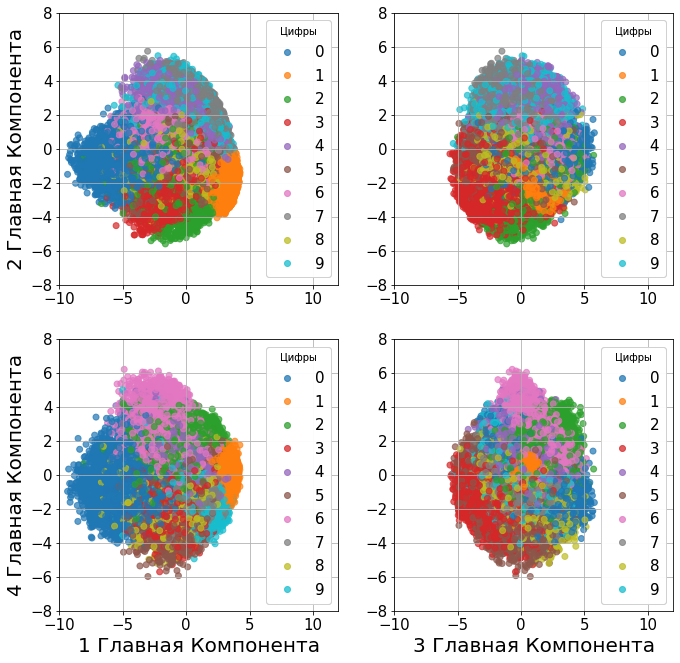

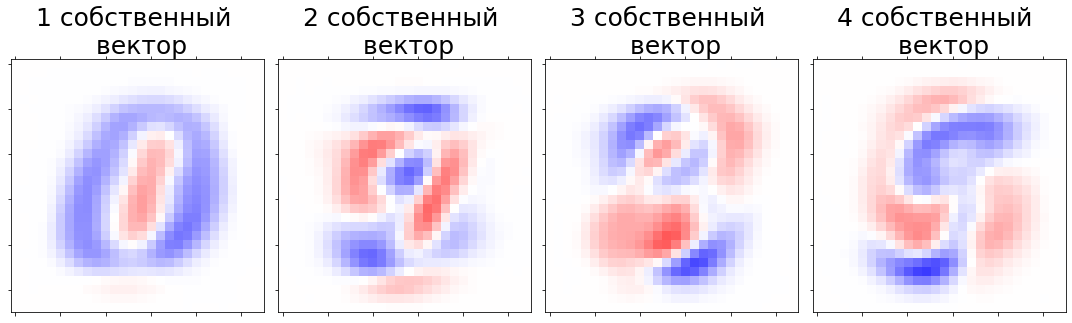

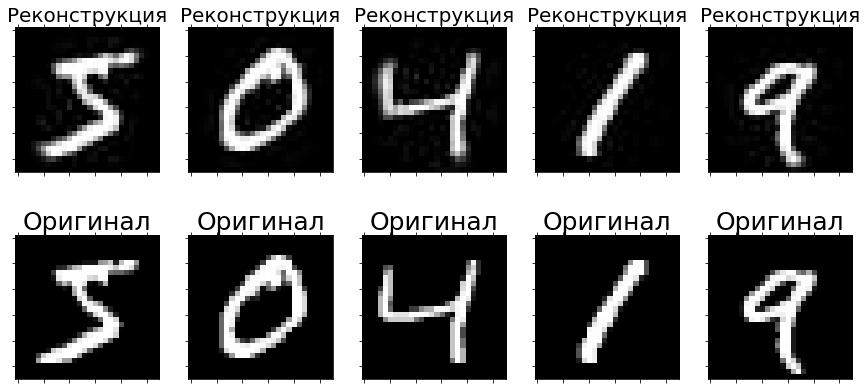

In [19]:
pca = PCA(n_components = 200)
pca.fit(X_)
pca.score(X_)
pca_result_mnist = pca.transform(X_)
pca_inverse = pca.inverse_transform(pca_result_mnist)
print(pca_inverse.shape)
pca_names = [str(x+1)+' Главная Компонента' for x in range(4)]
plot_multi(pca_result_mnist, y.astype(int), pca_names)
W_pca=pca.components.T
fig=plt.figure(figsize=(15,5))
for i in range(0,4):
    ax = fig.add_subplot(1,4,i+1,title=str(i+1) )
    ax.set_title("{} собственный \n вектор".format(str(i+1)), size=25)
    ax.matshow(W_pca[i].reshape((28,28)).astype(float), cmap = 'bwr', vmin=-0.20,vmax = 0.20)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
fig=plt.figure(figsize=(15,7))
for i in range(0,5):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_title("Реконструкция", size=20)  
    ax.matshow(1-pca_inverse[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
    ax = fig.add_subplot(2,5,i+6)
    ax.set_title("Оригинал", size=25)    
    ax.matshow(1-X_[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

In [20]:
pca.components.shape

(784, 200)

In [21]:
X_new = pca.transform(X)
X_new.shape

(70000, 200)

### Применим к данным набора mnist кластеризацию

**Метод локтя**

<ipython-input-23-50554ebbe62f>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 20)
<ipython-input-23-50554ebbe62f>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 20);


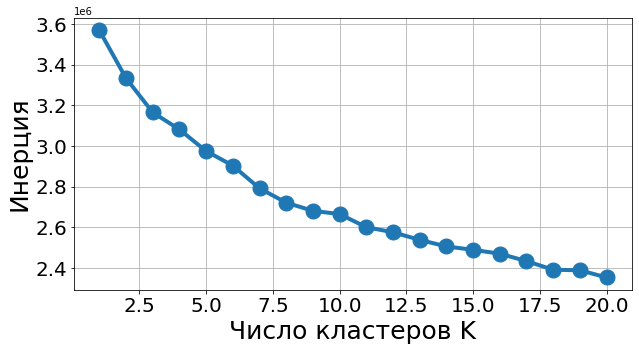

In [23]:
sse = []
list_k = list(range(1, 21))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_new)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(FontSize = 20)
plt.yticks(FontSize = 20);

Не совсем понятно, на графике визуально трудно обнаружить точку 'перегиба', поэтому, исходя из формальной логики возьмем 10 кластеров (по количеству цифр)

In [24]:
kmeans   = KMeans(n_clusters=10,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_new)

print('Мы остановились на итерации::',kmeans.iters)

Мы остановились на итерации:: 17


In [25]:
pd.crosstab(y,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3,4,5,6,7,8,9
Метки,,,,,,,,,,
0,217,3065,11,174,173,22,35,22,18,3166
1,8,0,3589,7,11,8,5,8,4241,0
2,399,118,415,219,172,4891,187,83,492,14
3,4590,141,62,54,1178,288,178,55,583,12
4,0,12,257,203,28,42,3716,2300,251,15
5,2047,274,496,123,1855,24,412,456,576,50
6,34,146,148,5609,141,98,81,2,492,125
7,5,14,312,5,12,56,2126,4304,443,16
8,1356,40,357,58,4049,64,210,239,411,41


Вывод: точность предсказания весьма посредственная из-за сложности кластеризации данных (видно на визуальзации набора)

## Набор данных Cars Moldova

Загрузка датафрейма данных

In [62]:
df = pd.read_csv('./Data/cars_moldova_clean_task1.csv', delimiter = ',')
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year,Quantile_km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,17727.272727,Large_km_year
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,16875.000000,Medium_km_year
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,11000.000000,Small_km_year
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,12500.000000,Medium_km_year
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,13636.363636,Medium_km_year


Первичный анализ данных

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32062 entries, 0 to 32061
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32062 non-null  object 
 1   Model                 32062 non-null  object 
 2   Year                  32062 non-null  int64  
 3   Style                 32062 non-null  object 
 4   Distance              32062 non-null  float64
 5   Engine_capacity(cm3)  32062 non-null  float64
 6   Fuel_type             32062 non-null  object 
 7   Transmission          32062 non-null  object 
 8   Price(euro)           32062 non-null  float64
 9   km_year               32062 non-null  float64
 10  Quantile_km_year      32062 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.7+ MB


Определим числовые и категориальные столбцы в данных

In [64]:
col_num = ['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']
col_cat = ['Year','Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Quantile_km_year']

### Применим кластеризация для цисловых данных

In [65]:
df_num = df[col_num]
X_new = df_num.values
X_new

array([[195000.        ,   1800.        ,   7750.        ,
         17727.27272727],
       [135000.        ,   1500.        ,   8550.        ,
         16875.        ],
       [110000.        ,   1500.        ,   6550.        ,
         11000.        ],
       ...,
       [ 89000.        ,   1500.        ,   7000.        ,
         12714.28571429],
       [370000.        ,   2000.        ,   4000.        ,
         23125.        ],
       [300000.        ,   1500.        ,   4000.        ,
         18750.        ]])

**Метод локтя**

<ipython-input-66-d363ba00e9c5>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 20)
<ipython-input-66-d363ba00e9c5>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 20);


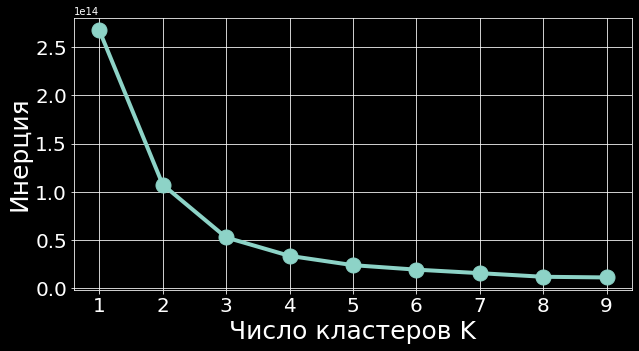

In [66]:
sse = []
list_k = list(range(1, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_new)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(FontSize = 20)
plt.yticks(FontSize = 20);

Будем считать, что оптимальное количество кластеров - 3

In [67]:
kmeans   = KMeans(n_clusters=3,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_new)

print('Мы остановились на итерации::',kmeans.iters)

Мы остановились на итерации:: 6


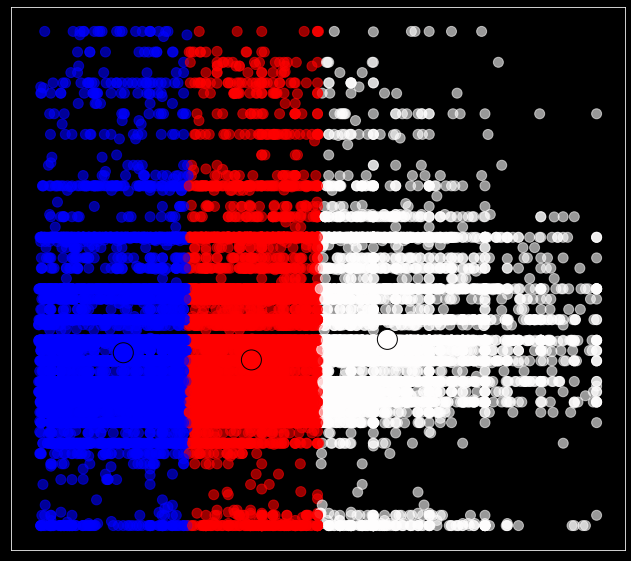

In [68]:
plot_cluster(X_new,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

### Связь кластеров с категориальными признаками

Возьмем на примере вида трансмиссии, которую мы уже считали раньшее в других моделях

In [69]:
df['Target'] = np.where((df['Transmission']=='Automatic'), 1, 0)
df = df.drop(['Transmission'], axis=1)
df.head(3)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Price(euro),km_year,Quantile_km_year,Target
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,7750.0,17727.272727,Large_km_year,1
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,8550.0,16875.000000,Medium_km_year,0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,6550.0,11000.000000,Small_km_year,0


In [70]:
target_name = 'Target'
y = df[target_name]

Посчитаем модель по 2 кластерам

In [71]:
kmeans   = KMeans(n_clusters=2,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_new)

print('Мы остановились на итерации::',kmeans.iters)

Мы остановились на итерации:: 5


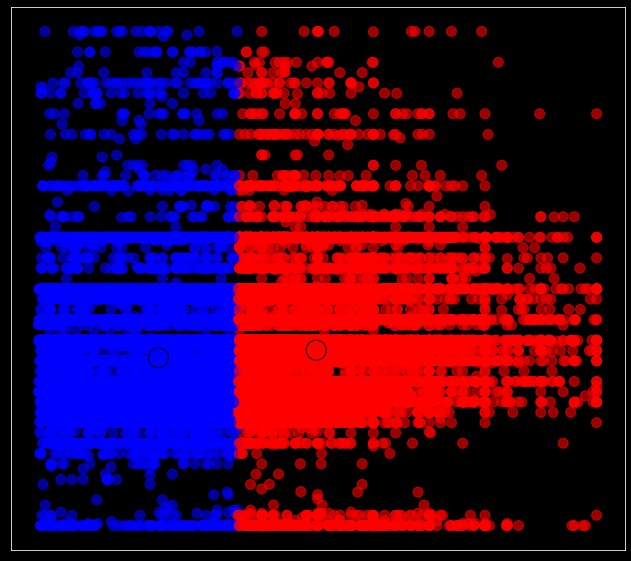

In [72]:
plot_cluster(X_new,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

In [73]:
pd.crosstab(y,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1
Метки,,
0,7048,10340
1,8581,6093


In [74]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [76]:
f1_score(y,c_labels)

0.39174462339666316

Ну такой себе результат...